# Bad Channel Lists

This notebook is a reference for generating a first list of bad channels that should be masked. It considers:
- noise run 534642 from 17 April 2023
- the number of tracklets from an MO in the test QCDB
- a list of bad channels by Ole
- the list of masked channels from the wingDB at Point 2

In [1]:
import ROOT
from IPython.display import display_html
%jsroot on

Welcome to JupyROOT 6.28/02


# Number of tracklets per MCM

The main issue with noisy channels is that they increase the data volume, and might impact the stability of the readout tree. We can focus on channels where this is a problem by looking at normal physics runs, and try to identify which MCMs send a larger number than tracklets.

The TRD QC already contains monitoring objects (MO) for the number of tracklets per MCM. I am using MOs from the test QCDB, which I assume are from a test of the QC TrackletsTask. It would be better to use a recent physics run with sufficient statistics, but I do not know how to directly access MOs from the production QCDB.

In [2]:
# create a place where we can store all information about (potentially) bad MCMs
mcminfo = dict()

In [3]:
ROOT.gROOT.LoadMacro("TrackletNoise.C");

In [5]:
mcmstats = ROOT.TrackletMCMStats(1684761589464, "http://ccdb-test.cern.ch:8080");

maxtracklets = mcmstats.GetMaxNTracklets()
maxtracklets

823835

We can check the histogram for the number of tracklets per MCM. We see that most MCMs find very few tracklets. Furthermore, there is a peak from MCMs with a bad channel that causes a tracklet to be found in every event. There are very few MCMs that find almost two tracklets per event, hinting at two noisy channels. And finally, we see a few MCMs with a moderate number of tracklets, indicating noisy, but potentially usable channels.

In [6]:
%jsroot on
cnv = ROOT.TCanvas()
cnv.SetLogy()
mcmdf = mcmstats.AddToDF(ROOT.BuildMcmDF());
h = mcmdf.Histo1D(("hNTracklletsZoom", "hNTracklletsZoom", 1000, 0, 1.05*maxtracklets), "ntracklets")
h.Draw()
cnv.Draw()

In [7]:
for k,v in mcmstats.FindNoisyMCMs(int(0.1*maxtracklets)):
    # print(k,v.ntracklets)
    if k not in mcminfo:
        mcminfo[k] = dict()
    mcminfo[k]["tqcdb"] = v.ntracklets
    
print(f"{len(mcminfo)} MCMs marked as noisy")

102 MCMs marked as noisy


# Ole's list of bad channels

On 16 May 2023, Ole suggested in an email to Tom and Benjamin a list of bad channels. The list is conservative, marking only MCMs as bad if a corresponding channel with high noise is found.

This list contains 60 channels in 43 MCMs.

In [8]:
# Read Ole's list of bad channels

import csv
from pprint import pprint

with open('listChannelsToBeMasked-Ole-20230516.csv', newline='') as csvfile:

    reader = csv.DictReader(csvfile)

    for row in reader:
        det = int(row['sector/I'])*30 + int(row['stack/I'])*6 + int(row['layer/I'])
        rob = int(row['rob/I'])
        mcm = int(row['mcm/I'])
        channel = int(row['channel/I'])
        chidx = ROOT.o2.trd.HelperMethods.getGlobalChannelIndex(det, rob, mcm, channel)
        mcmidx = chidx // 21
        
        if mcmidx not in mcminfo:
            mcminfo[mcmidx] = dict(ole = 1<<channel)
        elif "ole" in mcminfo[mcmidx]:
            mcminfo[mcmidx]["ole"] |= 1<<channel 
        else:
            mcminfo[mcmidx]["ole"] = 1<<channel 
        
print(f"{len(mcminfo)} MCMs marked by Ole")

104 MCMs marked by Ole


# Tom's list of noisy MCMs

In [16]:
import json
with open("noisy_mcms_tom.json") as f:
    data = json.load(f)
    for k,v in data.items():
        mcmidx = int(k)
        if mcmidx not in mcminfo:
            mcminfo[mcmidx] = dict(tom = int(v))
        else:
            mcminfo[mcmidx]["tom"] = int(v)

In [ ]:
def show_mcminfo(mcminfo):
    for idx,v in mcminfo.items():
        print(f"{idx:5d}:", end="   ")

        if ('tqcdb' in v):
            print(f"tQCDB: {v['tqcdb']:7}", end="   ")
        else:
            print('tQCDB:    --  ', end="   ")
        
        if ('tom' in v):
            print(f"Tom: {v['tom']:7}   ", end="   ")
        else:
            print('Tom:    --     ', end="   ")

        if ('ole' in v):
            print(f"Ole: 0x{v['ole']:06x}", end="   ")
        else:
            print('Ole:    --   ', end="   ")
        print()
        

In [19]:
show_mcminfo(mcminfo)

   15:   tQCDB:  413948   Tom:   50949      Ole:    --      
  867:   tQCDB:  279060   Tom:   11157      Ole: 0x000003   
  875:   tQCDB:  412076   Tom:   47027      Ole: 0x000003   
  883:   tQCDB:  196309   Tom:   22506      Ole: 0x000003   
  891:   tQCDB:  414273   Tom:   50955      Ole: 0x000003   
 2233:   tQCDB:  412823   Tom:   50818      Ole: 0x000200   
 2267:   tQCDB:  412212   Tom:   50662      Ole: 0x000008   
 2327:   tQCDB:  413187   Tom:   50874      Ole:    --      
 2335:   tQCDB:  395392   Tom:   48608      Ole:    --      
 3550:   tQCDB:  212110   Tom:   49904      Ole:    --      
 4887:   tQCDB:  412808   Tom:   50864      Ole:    --      
 4895:   tQCDB:  412563   Tom:   50861      Ole:    --      
 4903:   tQCDB:  412618   Tom:   50867      Ole:    --      
 4943:   tQCDB:  412652   Tom:   50850      Ole:    --      
 4951:   tQCDB:  412692   Tom:   50856      Ole:    --      
 4959:   tQCDB:  412556   Tom:   50855      Ole:    --      
 4967:   tQCDB:  412498 

In [20]:
set_ole = set([k for k,v in mcminfo.items() if "ole" in v])
set_tqcdb = set([k for k,v in mcminfo.items() if "tqcdb" in v])
set_tom = set([k for k,v in mcminfo.items() if "tom" in v])


set_ole_tqcdb = set_ole.intersection(set_tqcdb)

print(f"tQCDB: {len(set_tqcdb)} MCMs,  Ole: {len(set_ole)},  common: {len(set_ole_tqcdb)}")

tQCDB: 102 MCMs,  Ole: 43,  common: 41


/eos/user/t/tdietel/.local/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


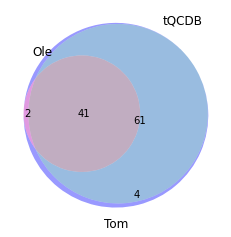

In [21]:
from matplotlib_venn import venn2, venn3
# venn2([set_ole, set_tqcdb], ("Ole", "tQCDB"))
venn3([set_ole, set_tqcdb, set_tom], ("Ole", "tQCDB", "Tom"))
# plt.plot

# Noise Run 534642

This noise run was taken on 17 April 2023. It serves as a first reference for noisy channels, but it would be usefule to have another run for comparision. We can access the CCDB objects for this run with the time stamp **1681740512656**.

We will use the macro `Detectors/TRD/macros/CheckNoiseRun.C` from the O2 Git repository to look at a summary of this run.

In [22]:
timestamp = 1681740512656 # for run 534642, taken on Mon Apr 17 16:08:32

In [23]:
ROOT.gROOT.LoadMacro("CheckNoiseRun.C");

We define a channel status classifier, which is used to classify and count problematic channels with the macro `CheckNoiseRun.C`. This classifation was not tuned to produce a stable list of bad channels, but it nevertheless gives a first indication of how many channels should be masked.

In [24]:
%%cpp

// Set up default classifier - easier in ROOT syntax

classifier = ChannelStatusClassifier({
    {"Good", kGreen + 1, 9.0, 10.2, 0.7, 1.8},
    {"LowNoise", kRed, 9.0, 10.2, 0.0, 0.7},
    {"Noisy", kRed, 9.0, 10.2, 1.8, 7.0},
    {"HighMeanRMS", kRed, 8.0, 25.0, 7.0, 30.0},
    {"HighMean", kRed, 10.5, 25.0, 2.0, 6.0},
    {"HighBaseline", kRed, 10.5, 520.0, 0.0, 10.0},
    {"VeryHighNoise", kRed, 0.0, 200.0, 30.0, 180.0},
    {"Ugly1", kRed, 200., 350., 15.0, 45.0},
    {"Ugly2", kRed, 200., 350., 45.0, 70.0},
    {"Ugly3", kRed, 350., 550., 10.0, 25.0},
    {"Ugly4", kRed, 350., 550., 25.0, 60.0}
});

In [25]:
df1 = ROOT.BuildNoiseDF(timestamp)
classifier = ROOT.classifier
df = classifier.AddToRDF(df1)

[INFO] ccdb reads http://ccdb-test.cern.ch:8080/TRD/Calib/ChannelStatus/1679064254530/28e85272-d858-11ed-9a2f-c0a80209250c for 1681740512656 (retrieve, agent_id: 7223ff7ec00b-1686130135-3d4py5), 


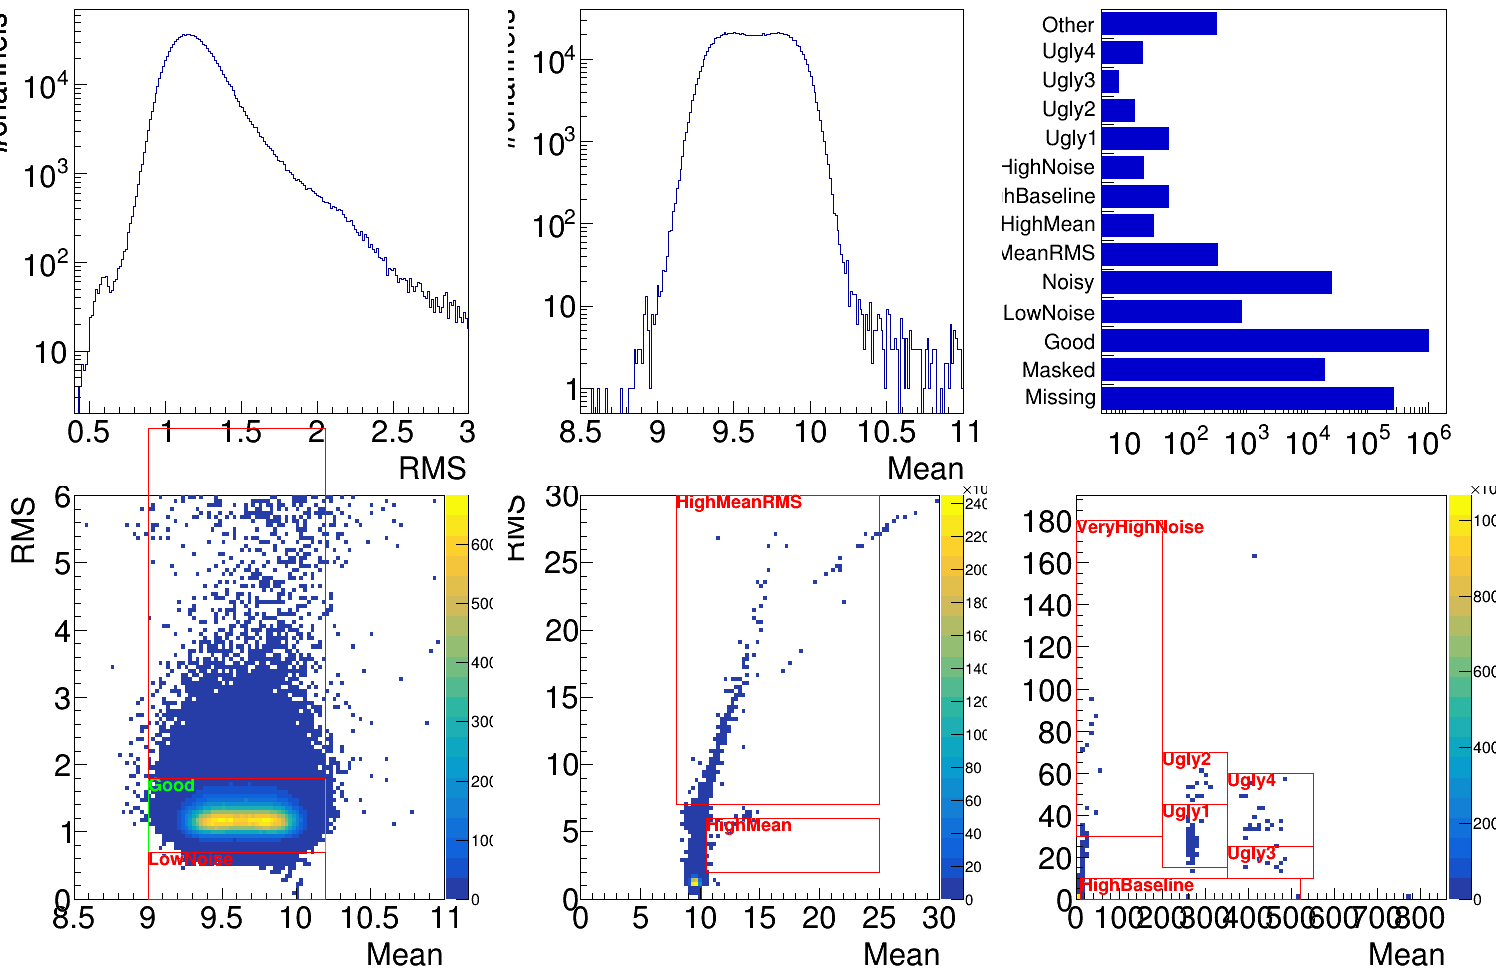

In [26]:
%jsroot off
ROOT.MakeRunSummary(df, classifier).Draw()

We can now use this data frame to generate a list of all channels in classes HighBaseline (stored as class=5), VeryHighNoise (class=6) and Ugly1-4 (classes 7-10). 

In [27]:
noisy_channel_df = df.Filter("class>=5")
noisy_channel_list = noisy_channel_df.Display("", 10)

print("Number of bad channels from noise run:", noisy_channel_df.Count().GetValue())
noisy_channel_list.Print()


Number of bad channels from noise run: 509
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| Row   | class | col | layer | mean     | nentries | rms      | row | sector | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 2643  | 11    | 123 | 0     | 10.2611f | 360      | 1.21958f | 15  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 12570 | 11    | 138 | 0     | 10.2389f | 360      | 1.52339f | 74  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 16253 | 11    | 125 | 1     | 266.000f | 360      | 0.00000f | 20  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18226 | 9     | 82  | 1     | 469.803f | 360      | 24.2482f | 32  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18227 | 9     | 83  | 1     | 478.953f | 360      | 17.6072f | 32  | 0

In [43]:
%%timeit -n 1 -r 1

for idx in mcminfo:
    idf = df.Filter(f"rdfentry_ / 21 == {idx}")
#     mcminfo[idx]['count_ptr'] = idf.Count()
    mcminfo[idx]['maxmean_ptr'] = idf.Max("mean")
    mcminfo[idx]['maxrms_ptr'] = idf.Max("rms")

582 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [44]:
for idx in mcminfo:
    keys = [k for k in mcminfo[idx] if k.endswith("_ptr")]
    for k in keys:
        mcminfo[idx][k[:-4]] = mcminfo[idx][k].GetValue()
        print(mcminfo[idx][k[:-4]])
    

0
10.0
1.8606007099151611
2
478.952880859375
24.248231887817383
2
485.9554748535156
18.79261016845703
2
473.3778076171875
14.040997505187988
2
440.324951171875
16.798250198364258
0
18.380550384521484
18.394208908081055
1
41.10832595825195
41.1105842590332
0
10.04166316986084
2.0709145069122314
0
10.0
1.8026989698410034
0
0.0
0.0
0
10.0
1.4931561946868896
0
10.0
1.6387578248977661
0
10.0
1.7134846448898315
0
10.0
1.6133943796157837
0
10.0055570602417
1.7818500995635986
0
10.03610897064209
1.9173556566238403
0
10.0
1.9265609979629517
0
10.0
1.9277969598770142
0
10.0
1.7364211082458496
0
10.0
1.9339096546173096
0
10.0
1.698438286781311
0
10.0
1.6213256120681763
0
10.0
1.7026609182357788
0
10.0
1.7328355312347412
0
9.861115455627441
1.2573691606521606
1
265.3165588378906
1.3912183046340942
2
265.7193908691406
1.4208511114120483
0
22.0
21.999998092651367
0
10.93889045715332
4.744192123413086
1
265.49713134765625
1.5040494203567505
2
274.0610656738281
27.30042266845703
2
271.2305603027344
29

In [45]:
pprint(mcminfo)

{15: {'count': 0,
      'count_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<ULong64_t> object at 0x2ec1b430>,
      'maxmean': 10.0,
      'maxmean_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2f00bcb0>,
      'maxrms': 1.8606007099151611,
      'maxrms_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2ebf2830>,
      'tom': 50949,
      'tqcdb': 413948},
 867: {'count': 2,
       'count_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<ULong64_t> object at 0x2fd75400>,
       'maxmean': 478.952880859375,
       'maxmean_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2e99af60>,
       'maxrms': 24.248231887817383,
       'maxrms_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2ecd2180>,
       'ole': 3,
       'tom': 11157,
       'tqcdb': 279060},
 875: {'count': 2,
       'count_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<ULong64_t> object at 0x2e88ada0>,
       'maxmean': 485.9554748535156,
       'maxmean_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2e950db0>

         'maxrms': 17.0155086517334,
         'maxrms_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2fbba8d0>,
         'ole': 8,
         'tom': 50908,
         'tqcdb': 413543},
 38455: {'count': 0,
         'count_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<ULong64_t> object at 0x2ea79fd0>,
         'maxmean': 10.0,
         'maxmean_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2dbc74f0>,
         'maxrms': 1.4000649452209473,
         'maxrms_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x232e3a70>,
         'tom': 49586,
         'tqcdb': 270286},
 38644: {'count': 0,
         'count_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<ULong64_t> object at 0x2eb633e0>,
         'maxmean': 0.0,
         'maxmean_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x2f7883c0>,
         'maxrms': 0.0,
         'maxrms_ptr': <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x312592f0>,
         'ole': 2,
         'tom': 50928,
         'tqcdb': 414434},
 39164: {'count': 

In [32]:
df.Filter(f"rdfentry_ / 21 == 875").Display().Print()

+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| Row   | class | col | layer | mean     | nentries | rms      | row | sector | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18375 | 0     | 63  | 1     | 9.53056f | 360      | 1.23115f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18376 | 0     | 64  | 1     | 9.51945f | 360      | 1.07220f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18377 | 0     | 65  | 1     | 9.64444f | 360      | 1.10866f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18378 | 0     | 66  | 1     | 9.44722f | 360      | 1.17023f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18379 | 0     | 67  | 1     | 9.26111f | 360      | 1.05601f | 33  | 0      | 
+-------+-------+-----+-------+---

In [49]:
%%cpp


// Aggregator function. It receives an accumulator (acc) and a column value (x). The variable acc is shared among the
// calls, so the function has to specify how the value has to be aggregated in the accumulator.
auto aggregator = [](ULong64_t acc, ULong64_t ch) { return acc |= 1<<ch; };
 
// If multithread is enabled, the aggregator function will be called by more threads and will produce a vector of
// partial accumulators. The merger function performs the final aggregation of these partial results.
auto merger = [](std::vector<ULong64_t> &accumulators) {
  auto size = accumulators.size();
  for (int i = 1; i < size; ++i) {
    accumulators[0] |= accumulators[i];
  }
};

In [58]:
%%cpp

ROOT::RDF::RResultPtr<ULong64_t> BuildMask2(ROOT::RDF::RNode df)
{
    // The accumulator is initialized at this value by every thread.
    ULong64_t initValue = 0;
    
    // Multiplies all elements of the column "x"
    return df.Define("channel", "rdfentry_ % 21").Aggregate(aggregator, merger, "channel", initValue);
}

In [53]:
df.Filter(f"rdfentry_ / 21 == 875").Display().Print()

+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| Row   | class | col | layer | mean     | nentries | rms      | row | sector | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18375 | 0     | 63  | 1     | 9.53056f | 360      | 1.23115f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18376 | 0     | 64  | 1     | 9.51945f | 360      | 1.07220f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18377 | 0     | 65  | 1     | 9.64444f | 360      | 1.10866f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18378 | 0     | 66  | 1     | 9.44722f | 360      | 1.17023f | 33  | 0      | 
+-------+-------+-----+-------+----------+----------+----------+-----+--------+
| 18379 | 0     | 67  | 1     | 9.26111f | 360      | 1.05601f | 33  | 0      | 
+-------+-------+-----+-------+---

In [65]:
bla = ROOT.BuildMask2(df.Filter("rms > 5"))
bla.Display.Print()

TypeError: ROOT::RDF::RResultPtr<ULong64_t> ::BuildMask2(ROOT::RDF::RInterface<ROOT::Detail::RDF::RNodeBase,void> df) =>
    TypeError: could not convert argument 1

In [63]:
print(f"{bla.GetValue():06x}")

1fffff
